### PEP Analysis based on Gallo et al (2021)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.sparse.csgraph import shortest_path, dijkstra

from scripts.auxiliar import spherical2cartesian, cartesian2spherical, GCD_cartesian

In [99]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"

df_NAM = pd.read_excel(data_path_PP + file_name)
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

N = df_NAM.shape[0]

df_NAM = df_NAM.sort_values(by="age")
df_NAM

,name,min_age,max_age,age,slat,slon,N,k,alpha95,dp,...,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints,x,y,z
1,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,8.5,...,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study),0.919264,0.054671,0.389827
0,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,NaN,...,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron,-0.166445,-0.038510,-0.985298
2,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,6.9,...,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...,-0.026142,0.029794,0.999214
3,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,3.5,...,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated),-0.677365,0.517281,0.523066
4,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,7.9,...,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy,-0.560750,0.043746,0.826829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Tatnic Complex,120.0,124.0,122.0,43.30,289.30,10,113.0,4.6,NaN,...,65.7,-19.8,55.3,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...","122±2; K-Ar on biotite in gabbro, Ar-Ar on bio...",0.747284,0.209616,-0.630578
61,Monteregian Hills intrusives,117.0,127.0,122.0,45.30,286.80,70,49.2,2.4,2.8,...,65.7,-19.8,55.3,Foster and Symons (1979),6,NaN,118±4 Ma Rb-Sr; 123±4 K-Ar,-0.152678,-0.198468,0.968142
62,White Mountains igneous complex,119.0,126.0,122.5,43.50,288.30,8,274.9,3.3,4.2,...,65.7,-19.8,55.3,Van Fossen and Kent (1992),5,NaN,Ar/Ar age of 122.5±3.5,0.662223,-0.588503,-0.463816
63,Lebanon diorite,122.0,128.0,125.0,43.40,289.20,5,113.0,7.5,NaN,...,65.4,-18.9,56.8,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...",125±3 Ma K-Ar on biotite. They discarded disco...,0.822666,0.144162,-0.549944


In [7]:
%%time
n_min = 5   # minimum lenght of a segment in a APWP
n_max = N

min_apical = 30
n_initials = 2

Adj_matrix = np.full((N, N), np.inf)
EPs = np.full((N, N, 3), np.nan, dtype=object)
Apicals = np.full((N, N), np.nan)

for i in range(N):
    
    for j in range(i + n_min, i + n_max + 1):
                
        if j >= N:
            continue
            
        # We need to define the loss function from zero since it has the PP inside the function        
        X = df_NAM[i:j+1][['x', 'y', 'z']].to_numpy()
                        
        # If the first and last point are too close in relation to the other points of the segments, this indicates
        # the presence two different EPs with overlapping segments moving in opposite directions
        pp_i, pp_f = X[0], X[-1]
        # do this with geodesic distance! 
        
        #path_distance = GCD_cartesian(pp_i, pp_f)
        #max_dist = np.max([GCD_cartesian(X[k], X[m]) for m in range(X.shape[0]) for k in range(m+1,X.shape[0])])
        #if path_distance < 0.8 * max_dist:
        #    continue
             
        def loss (v):
            theta, phi, varphi = v[0], v[1], v[2]                   
            res = 0
            pole = spherical2cartesian(theta, phi)
            for k in range(X.shape[0]):
                res += ( np.arccos( np.dot( X[k,:], pole)) - varphi ) ** 2        
            return res
        
        
        best = np.inf        
        for _ in range(n_initials): #number of iterations
                
            initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(min_apical * (np.pi/180), np.pi / 2)] #set up random initial guess        
            optimum_tmp = minimize(loss, x0 = np.array(initialGuess), method = "CG", options = {'gtol': 1E-10})
                        
            if optimum_tmp.fun < best and optimum_tmp.x[-1] > min_apical * (np.pi/180): 
                optimum = optimum_tmp
                best = optimum_tmp.fun
                #initialGuess = [optimum_tmp.x[0], optimum_tmp.x[1], optimum_tmp.x[2]]
                
        if best < np.inf:      
            Adj_matrix[i,j] = optimum.fun
            EPs[i,j,:] = spherical2cartesian(optimum.x[0], optimum.x[1])
            Apicals[i,j] = optimum.x[2] 

CPU times: user 2min 31s, sys: 772 ms, total: 2min 32s
Wall time: 2min 32s


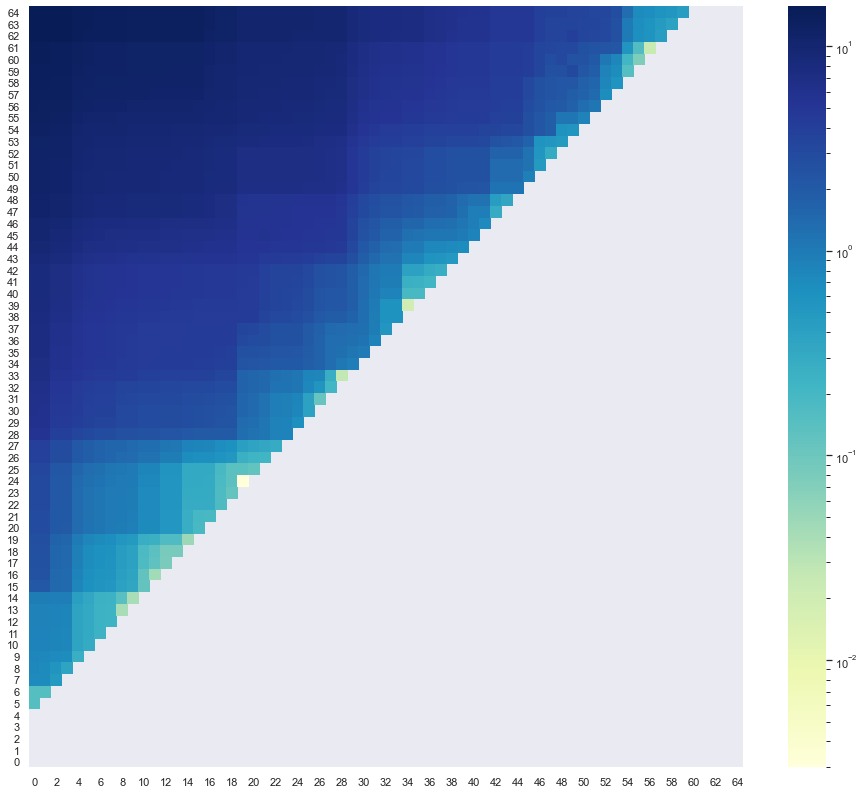

In [22]:
from matplotlib.colors import LogNorm
Adj_matrix_df = pd.DataFrame(Adj_matrix.transpose())
# Adj_matrix_df.to_csv('Adj_matrix.csv')
sns.set(rc={'figure.figsize':(16,14)})

# Default heatmap
#sns.heatmap(Adj_matrix_df, vmin=.000001, cmap="YlGnBu").invert_yaxis()
sns.heatmap(Adj_matrix_df, cmap="YlGnBu", robust=True, norm=LogNorm()).invert_yaxis()

In [17]:
np.max(Adj_matrix)

inf

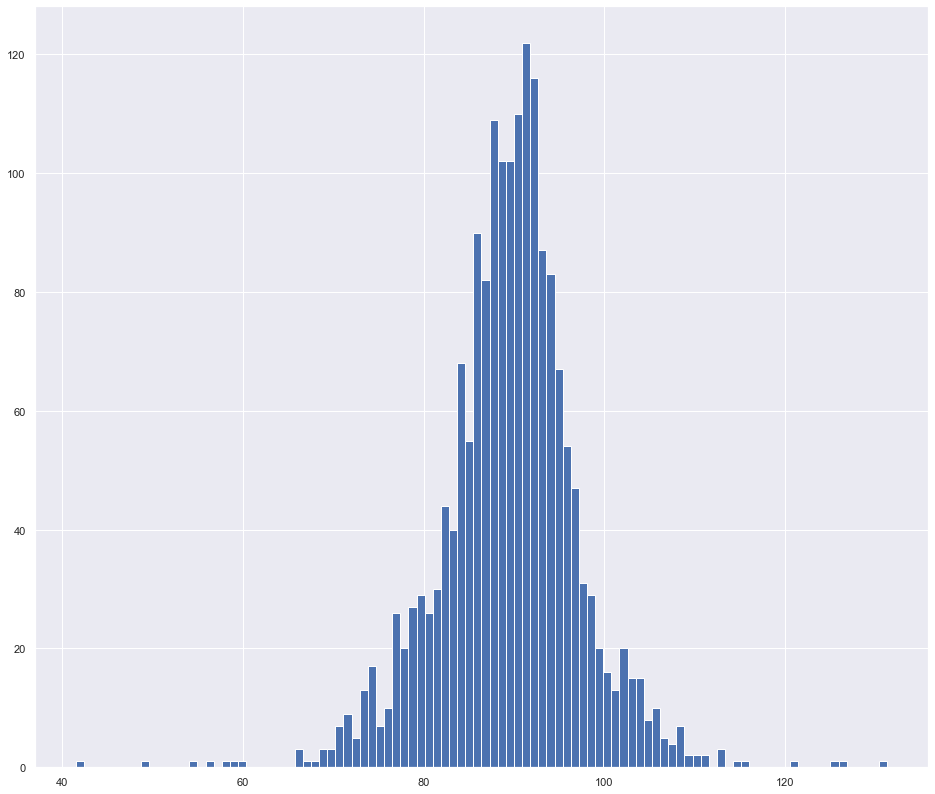

In [10]:
plt.hist(np.abs((180/np.pi)*Apicals.ravel()), 100);

In [40]:
def get_changepoints(Adj_matrix, reg = 0.0001):
    '''
    Given the Adjacency matrix and the regularization parameter, returns a list with changepoints along with the distance matrix
    '''    
    
    dist_matrix, predecesors = shortest_path(Adj_matrix + reg, 
                                             return_predecessors = True)
    
    res = []
    x = predecesors[0, -1]
    
    while x != 0:
        
        res.append(x)
        x = predecesors[0, x]
        
    return list(reversed(res)), dist_matrix[0,-1]

In [109]:
df_NAM.age[9]

4.5

In [123]:
N_lamb = 1000

all_lamb_log = np.linspace(-1, 1, N_lamb)
all_lamb = 10 ** all_lamb_log

all_cost, all_nsegments = [], []

Tree = np.full((N, N_lamb), 0)
Tree_lamb = []
Tree_age = []

for i, lamb in enumerate(all_lamb):    
    
    changepoints, cost = get_changepoints(Adj_matrix, reg=lamb)
    #print(changepoints)
    
    for x in changepoints:
        Tree[x, i] = 1
        Tree_lamb.append(np.log10(lamb))
        Tree_age.append(df_NAM.age[x])
    
    loss_reg = lamb * len(changepoints)
    loss1 = cost - loss_reg
    
    all_nsegments.append(len(changepoints))
    all_cost.append(cost)

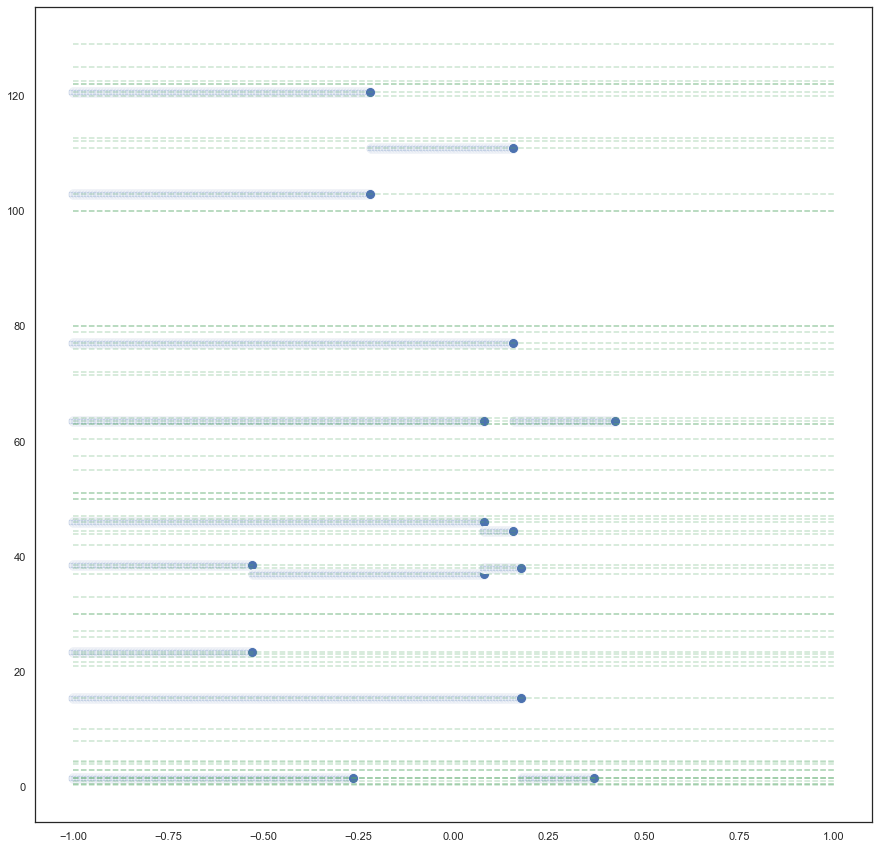

In [140]:
sns.set_style("white")
plt.hlines(y=df_NAM.age.values, xmin=all_lamb_log[0], xmax=all_lamb_log[-1], color='g', linestyle='--', alpha=.3)
sns.scatterplot(x=Tree_lamb, y=Tree_age, s=100, alpha=1)


In [ ]:
plt.imshow(Tree_df, "Greys", aspect=5)

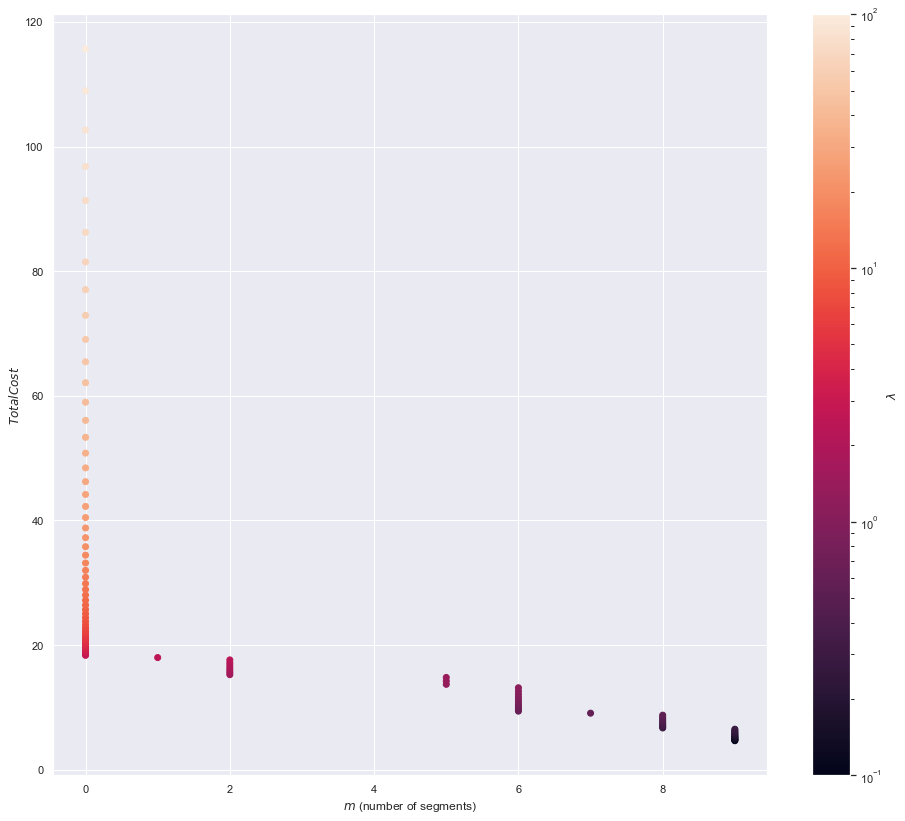

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(all_nsegments,all_cost,c=all_lamb, norm=LogNorm())
plt.ylabel('$Total Cost$', size = 12)
plt.xlabel('$m$ (number of segments)', size = 12)
#plt.ylim(0,.001)
#plt.yscale('log')
plt.colorbar(label = '$\lambda$')
plt.savefig('elbow.pdf', dpi =600)
plt.show()